In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import spacy
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

### Read Spam Emails:

Some of the documents in our dataset are encoded in ISO-8859, which will cause issues as we try to process the data. We'll need to convert these files to UTF-8 or ASCII. One way we can convert the encoding is using Linux's `inconv` package, which is pre-installed in most distros.

We can check the file's current encoding like so, where `FILE_NAME.txt` is the name of the file:
```bash
file -i FILE_NAME.txt
```

```bash
iconv -f ISO-8859-1 -t UTF-8//TRANSLIT FILE_NAME.txt -o FILE_NAME.txt
```

In [3]:
spam_file_paths = glob.iglob('../data/enron/**/spam/**')
df_spam = pd.DataFrame(columns=['text', 'label'])

In [3]:
for file_path in spam_file_paths:
    text = ''
    with open(file_path, 'r') as file:
        for line in file:
            text += line
        df_spam = pd.concat([df_spam, pd.DataFrame({'text': text, 'label': [1]})], ignore_index=True)

### Read Ham Emails:

In [4]:
ham_file_paths = glob.iglob('../data/enron/ham/**')
df_ham = pd.DataFrame(columns=['text', 'label'])

In [5]:
for file_path in ham_file_paths:
    text = ''
    with open(file_path, 'r') as file:
        for line in file:
            text += line

        df_ham = pd.concat([df_ham, pd.DataFrame({'text': text, 'label': [0]})], ignore_index=True)

### Explore Dataset:

##### Labels:
**1**: spam
**0**: ham

In [6]:
# Spam examples:
df_spam.head()

,text,label
0,"Subject: colloquy\nhi , this is christine repl...",1
1,Subject: hey\ntuscany selfish avert fitch cant...,1
2,Subject: time is right to invest in the euro -...,1
3,Subject: breaking news\ndon ' t you practice c...,1
4,"Subject: the investor ' s toolbox\nmcintyre ,\...",1


In [7]:
# Ham examples:
df_ham.head()

,text,label
0,Subject: re : interconnect / intercompany issu...,0
1,Subject: clickathome portal is here !\nversion...,0
2,"Subject: cleburne\ndaren & john ,\nsee the att...",0
3,Subject: developmental plan\nplease reference ...,0
4,Subject: neither ena / rac / egf employees nor...,0


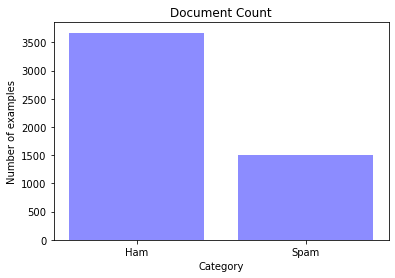

In [8]:
# Set size of plot:
plt.rcParams["figure.figsize"] = (8, 8)

fig, ax = plt.subplots()
ax.bar(
    ['Ham', 'Spam'],
    [len(df_ham), len(df_spam)],
    color='blue',
    alpha=0.45
)

plt.title('Document Count')
plt.xlabel('Category')
plt.ylabel('Number of examples')
plt.show()

In [9]:
len_ham = len(df_ham)
len_spam = len(df_spam)
print('Ham Count:', len_ham)
print('Spam Count:', len_spam)
print('Total:', len_spam + len_ham)

Ham Count: 3672
Spam Count: 1500
Total: 5172


In [37]:
combined_dataset = pd.concat([df_ham, df_spam])
x_dataset = combined_dataset['text']
y_dataset = combined_dataset['label'].astype(int)

In [38]:
# combined_dataset.to_csv('../data/enron1.csv', index=False, escapechar='\\')

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=.2, random_state=12)

In [15]:
print('Size of train set:', len(x_train))
print('Size of test set:', len(x_test))

Size of train set: 4137
Size of test set: 1035


## Process Data:

In [16]:
# We only need lemmatizer from spaCy:
# see <https://spacy.io/usage/processing-pipelines#disabling>
nlp = spacy.load('en_core_web_trf',
                 disable=['tagger', 'parser', 'ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel',
                          'attribute_ruler', 'senter', 'sentencizer', 'tok2vec', 'transformer']
                 )

In [17]:
# remove stop words (parameter scaling):
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

## Support Vector Machine:

In [40]:
model_SVM = Pipeline(
    [
        ('vectorizer', TfidfVectorizer(stop_words=spacy_stopwords)),
        ('classifier', LinearSVC())
    ])

model_SVM.fit(x_train, y_train)

/home/deesus/.miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('classifier', LinearSVC())])

In [43]:
print('Train Accuracy:', model_SVM.score(x_train, y_train))
print('Test accuracy:', model_SVM.score(x_test, y_test))

Train Accuracy: 1.0
Test accuracy: 0.9903381642512077


In [86]:
def predict_files(spam_glob_path: str, ham_glob_path: str, model):
    spam_file_paths = glob.iglob(spam_glob_path)
    ham_file_paths = glob.iglob(ham_glob_path)

    _labels = []
    _predictions = []

    i = 0
    for file_paths in (ham_file_paths, spam_file_paths):
        for file_path in file_paths:
            _labels.append(i)
            with open(file_path, 'r') as file:
                predict = model.predict(file)
                if sum(predict) / len(predict) >= .5:
                    _predictions.append(1)
                else:
                    _predictions.append(0)
        i += 1
    return _predictions, _labels

In [70]:
predictions, labels = predict_files('../data/enron1/spam/**', '../data/enron1/ham/**', model_SVM)

In [72]:
f1_score(labels, predictions, average="macro")

0.9179542812217298

### XGBoost

In [74]:
model_xgb = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=spacy_stopwords)),
    ('classifier', XGBClassifier(objective='binary:logistic'))
])

model_xgb.fit(x_train, y_train)

/home/deesus/.miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtre...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [91]:
print('Train accuracy:', model_xgb.score(x_train, y_train))
print('Test accuracy:', model_xgb.score(x_test, y_test))

Train accuracy: 0.9968576262992507
Test accuracy: 0.9729468599033816


In [75]:
file_paths = glob.iglob('../data/enron1/spam/**')

In [93]:
predictions, labels = predict_files('../data/enron1/spam/**', '../data/enron1/ham/**', model_xgb)

In [94]:
f1_score(labels, predictions, average="macro")

0.42939030125365296